In [2]:
# Import necessary libraries
import torch
import numpy as np
import pandas as pd
import diffprivlib.models as dp
from sklearn.linear_model import LogisticRegression
from torch import nn, optim
from opacus import PrivacyEngine
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader


# Importing train, test split library
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# efficacy metrics from sklearn
from sklearn import metrics


#import visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
# bias
# holisticai imports
import holisticai
from holisticai.bias.metrics import classification_bias_metrics
from holisticai.bias.mitigation.postprocessing import CalibratedEqualizedOdds, RejectOptionClassification

## Load Training and Testing Data

In [3]:
# # Load the data
# X_train = pd.read_csv('../../data/X_train.csv',index_col=0).drop(['id'],axis=1)
# y_train = pd.read_csv('../../data/y_train.csv',index_col=0)
# X_test = pd.read_csv('../../data/X_test.csv',index_col=0).drop(['id'],axis=1)
# y_test = pd.read_csv('../../data/y_test.csv',index_col=0)

In [4]:
baseline__df = pd.read_csv("../../data/data_baseline.csv",index_col=0)
baseline__df.head()

,sex,age,juv_fel_count,juv_misd_count,juv_other_count,priors_count,c_charge_desc,two_year_recid,time_in_custody_in_days,time_in_jail_in_days,African-American_race,Asian_race,Hispanic_race,Native American_race,Other_race,Felony_c_charge_degree,High_score_text,Low_score_text,High_v_score_text
id,,,,,,,,,,,,,,,,,,,
1,1,69,0,0,0,0,0.282331,0,7.0,0.0,0,0,0,0,1,1,0,1,0
3,1,34,0,0,0,0,0.568689,1,10.0,10.0,1,0,0,0,0,1,0,1,0
4,1,24,0,0,1,4,0.600344,1,0.0,1.0,1,0,0,0,0,1,0,1,0
5,1,23,0,1,0,1,0.368006,0,0.0,0.0,1,0,0,0,0,1,1,0,0
6,1,43,0,0,0,2,0.439192,0,0.0,0.0,0,0,0,0,1,1,0,1,0


In [5]:
baseline__df.columns

Index(['sex', 'age', 'juv_fel_count', 'juv_misd_count', 'juv_other_count',
       'priors_count', 'c_charge_desc', 'two_year_recid',
       'time_in_custody_in_days', 'time_in_jail_in_days',
       'African-American_race', 'Asian_race', 'Hispanic_race',
       'Native American_race', 'Other_race', 'Felony_c_charge_degree',
       'High_score_text', 'Low_score_text', 'High_v_score_text'],
      dtype='object')

In [6]:
baseline__df = baseline__df.drop(['Asian_race','Hispanic_race','Other_race','High_score_text','High_v_score_text','Low_score_text','Native American_race'],axis=1)

In [7]:
baseline__df.columns

Index(['sex', 'age', 'juv_fel_count', 'juv_misd_count', 'juv_other_count',
       'priors_count', 'c_charge_desc', 'two_year_recid',
       'time_in_custody_in_days', 'time_in_jail_in_days',
       'African-American_race', 'Felony_c_charge_degree'],
      dtype='object')

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    baseline__df.drop(["two_year_recid"], axis=1),
    baseline__df["two_year_recid"],
    test_size=0.2,
    random_state=1000,
    stratify=baseline__df["two_year_recid"],
)

In [9]:
y_train = pd.DataFrame(y_train)
y_test = pd.DataFrame(y_test)

## Transform Data for the Model

In [10]:
group_a_train = X_train["African-American_race"] == 1
group_b_train = X_train["African-American_race"] == 0
data_train = [X_train, y_train, group_a_train, group_b_train]


group_a_test = X_test["African-American_race"] == 1
group_b_test = X_test["African-American_race"] == 0
data_test = [X_test, y_test, group_a_test, group_b_test]	

In [11]:
# group_a_train = X_train["sex"] == 1
# group_b_train = X_train["sex"] == 0
# data_train = [X_train, y_train, group_a_train, group_b_train]


# group_a_test = X_test["sex"] == 1
# group_b_test = X_test["sex"] == 0
# data_test = [X_test, y_test, group_a_test, group_b_test]


Defining the functions to calcluate the perfomace metrics

In [65]:

# dictionnary of metrics
metrics_dict={
        "Accuracy": metrics.accuracy_score,
        "Balanced accuracy": metrics.balanced_accuracy_score,
        "Precision": metrics.precision_score,
        "Recall": metrics.recall_score,
        "F1-Score": metrics.f1_score}

# efficacy metrics dataframe helper tool
def metrics_dataframe(y_pred, y_true, metrics_dict=metrics_dict):
    metric_list = [[pf, fn(y_true, y_pred)] for pf, fn in metrics_dict.items()]
    return pd.DataFrame(metric_list, columns=["Metric", "Value"]).set_index("Metric")

In [13]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [14]:
# Check the shapes of the scaled data
X_train_scaled.shape, X_test_scaled.shape, y_train.shape, y_test.shape

((5748, 11), (1437, 11), (5748, 1), (1437, 1))

Checking Prediction distribution in training and test data

In [15]:
test_df = X_test.copy()
test_df['y_test'] = y_test

In [16]:
test_proportion = test_df[['African-American_race','y_test']]
test_proportion = test_proportion.groupby(['African-American_race']).aggregate(['sum','count'])
test_proportion['prop_of_recidivism'] = test_proportion['y_test']['sum']/test_proportion['y_test']['count']
test_proportion

y_test       prop_of_recidivism
                         sum count                   
African-American_race                                
0                        269   707           0.380481
1                        378   730           0.517808

## Baseline Logistic Regression Model

In [17]:
baseline_lr = LogisticRegression(solver="lbfgs", max_iter=1000)
baseline_lr.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=1000)

In [18]:
y_pred = baseline_lr.predict(X_test_scaled)
y_proba = baseline_lr.predict_proba(X_test_scaled)
y_score = y_proba[:,1]
y_true = y_test

#adding to the dataframe for analysis purpose
test_df['y_pred_lrb'] = y_pred
test_df['y_score_lrb'] = y_score

Model Performance

In [19]:
# Baseline efficacy
metrics_dataframe(y_pred, y_true)

,Value
Metric,
Accuracy,0.698678
Balanced accuracy,0.689859
Precision,0.689716
Recall,0.601236
F1-Score,0.642444


Fairness Performance

In [20]:
fairness_metrics = classification_bias_metrics(group_a_test, group_b_test, y_pred, y_true, metric_type='both')
fairness_metrics.iloc[6]

Value        0.123106
Reference    0.000000
Name: False Positive Rate Difference, dtype: float64

In [21]:
test_proportion = test_df[['African-American_race','y_pred_lrb']]
test_proportion = test_proportion.groupby(['African-American_race']).aggregate(['sum','count'])
test_proportion['prop_of_recidivism'] = test_proportion['y_pred_lrb']['sum']/test_proportion['y_pred_lrb']['count']
test_proportion

y_pred_lrb       prop_of_recidivism
                             sum count                   
African-American_race                                    
0                            198   707           0.280057
1                            366   730           0.501370

Model exacerbated the bias

In [22]:
list(X_train.columns)

['sex',
 'age',
 'juv_fel_count',
 'juv_misd_count',
 'juv_other_count',
 'priors_count',
 'c_charge_desc',
 'time_in_custody_in_days',
 'time_in_jail_in_days',
 'African-American_race',
 'Felony_c_charge_degree']

In [23]:
feature_imp_baseline = pd.DataFrame({'Varibale' : list(X_train.columns), 'coeff' : list(baseline_lr.coef_[0])})
feature_imp_baseline.sort_values(by='coeff',ascending=False)

,Varibale,coeff
6,c_charge_desc,0.725889
5,priors_count,0.624495
8,time_in_jail_in_days,0.189535
4,juv_other_count,0.133150
7,time_in_custody_in_days,0.114599
2,juv_fel_count,0.102986
0,sex,0.102928
9,African-American_race,0.028342
3,juv_misd_count,0.004700
10,Felony_c_charge_degree,-0.131001


<AxesSubplot:xlabel='y_score_lrb', ylabel='Density'>

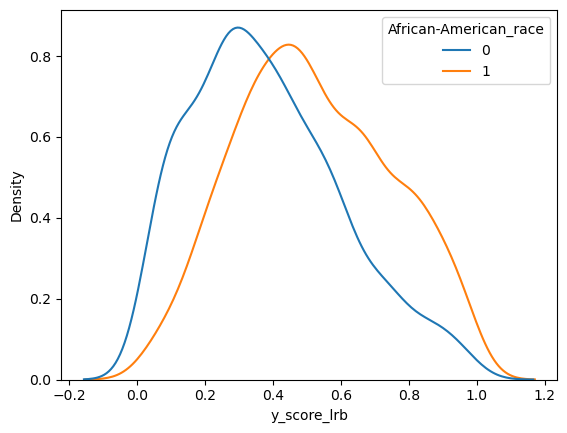

In [24]:
sns.kdeplot(data=test_df, x= 'y_score_lrb',hue='African-American_race')

## Differentially Private Logistic Regression Model


epsilon (ε) represents the maximum acceptable difference in the model's output when the dataset is modified by adding or removing a single data point. 
Intuition: 
When epsilon is provided to a logistic regression model, it guides the model to learn a representation of the data that is less sensitive to individual changes.

By introducing epsilon, the logistic regression model limits the amount of information that can be inferred about any single individual. This is achieved by adding noise to the model's parameters or predictions, making it difficult for an adversary to discern the impact of any single data point.

This is equivalent to learning Fair Representation in terms of Fairness, whereas individual's association witht the outcome is obfuscated, and therefore we expect to see fairer model just by introducing the privacy budget

To-do : *write a loop plot*

In [25]:
dp_clf = dp.LogisticRegression(random_state=0,epsilon=10)
dp_clf.fit(X_train_scaled, y_train)

LogisticRegression(accountant=BudgetAccountant(spent_budget=[(10, 0)]),
                   data_norm=30.38800759702258, epsilon=10, random_state=0)

In [26]:
#predicting on train
y_pred_dp_train = dp_clf.predict(X_train_scaled)
y_proba_dp_train = dp_clf.predict_proba(X_train_scaled)
y_score_dp_train = y_proba_dp_train[:,1]

#predicting on test
y_pred_dp = dp_clf.predict(X_test_scaled)
y_proba_dp = dp_clf.predict_proba(X_test_scaled)
y_score_dp = y_proba_dp[:,1]


#insering in test df
test_df['y_pred_dp'] = y_pred_dp
test_df['y_score_dp'] = y_score_dp


Private Model Performance

In [27]:
# Baseline efficacy
metrics_dataframe(y_pred_dp, y_true)

,Value
Metric,
Accuracy,0.697982
Balanced accuracy,0.690205
Precision,0.683938
Recall,0.612056
F1-Score,0.646003


Private Model Fairness Performance

In [28]:
fairness_metrics_dp = classification_bias_metrics(group_a_test, group_b_test, y_pred_dp, y_true, metric_type='both')
fairness_metrics_dp.iloc[6]

Value        0.125337
Reference    0.000000
Name: False Positive Rate Difference, dtype: float64

Private Model Fairness Interpretation

In [29]:
feature_imp_dp = pd.DataFrame({'Varibale' : list(X_train.columns), 'coeff' : list(dp_clf.coef_[0])})
feature_imp_dp.sort_values(by='coeff',ascending=False)

,Varibale,coeff
6,c_charge_desc,0.701089
5,priors_count,0.691110
8,time_in_jail_in_days,0.255380
4,juv_other_count,0.124578
2,juv_fel_count,0.074533
7,time_in_custody_in_days,0.043191
0,sex,0.039016
9,African-American_race,0.001030
3,juv_misd_count,-0.022961
10,Felony_c_charge_degree,-0.103773


In [30]:
print("Privacy Measure : ", dp_clf.epsilon)
print("Fairness measure: ", fairness_metrics_dp.iloc[6][0])

Privacy Measure :  10
Fairness measure:  0.1253372768783728


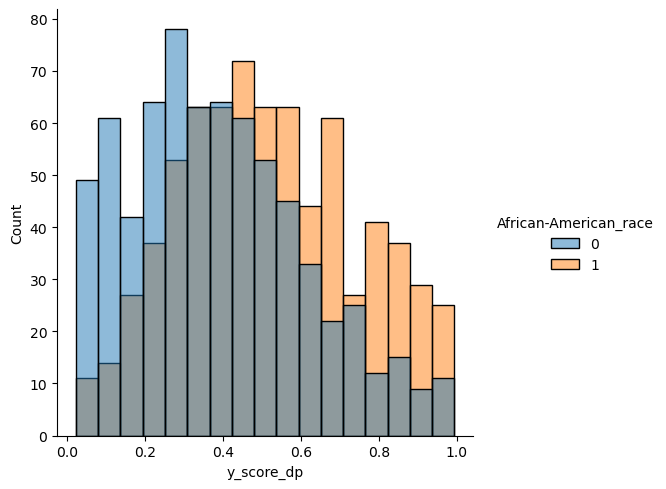

In [47]:
sns.displot(data=test_df, x= 'y_score_dp',hue= 'African-American_race')

In [32]:
test_proportion = test_df[['African-American_race','y_pred_dp']]
test_proportion = test_proportion.groupby(['African-American_race']).aggregate(['sum','count'])
test_proportion['prop_of_recidivism'] = test_proportion['y_pred_dp']['sum']/test_proportion['y_pred_dp']['count']
test_proportion

y_pred_dp       prop_of_recidivism
                            sum count                   
African-American_race                                   
0                           206   707           0.291372
1                           373   730           0.510959

## Implementing Fairness

### Reject Option Classification

Explaination:
this approach is applicable to different fairness definitions as well. Fairness Definition agnostic.
More practical as it works on benefit of doubt model, and does not make 'confidently wrong' predictions
Cons : 
Does not optimize for FPRD
Solution?
Optimize for 'Statistical Parity Difference'? 
Statistical parity difference measures the difference in the positive prediction rate/Precision between the privileged and unprivileged groups. so if we set low and high threshold smartly, it will optinize for FRPD by maximizing the precision. 
Can't use AOD and EOD because they optimize for Recall. not what we want.

#### roc plot

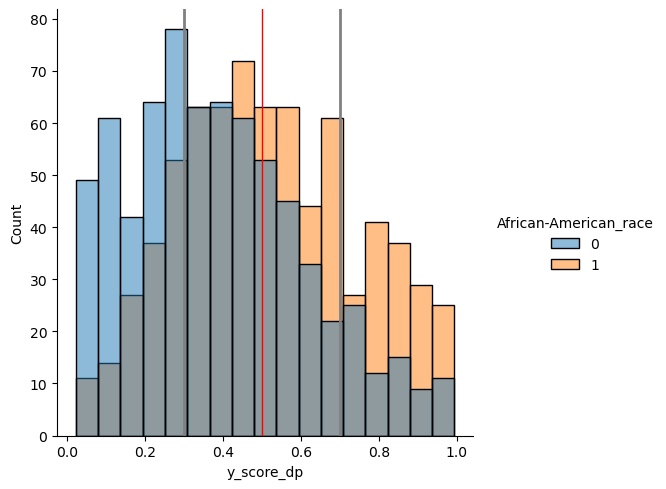

In [34]:
#investigating the most uncertain region
sns.displot(data=test_df, x= 'y_score_dp',hue= 'African-American_race')
# Add dotted lines
plt.axvline(x=0.3, color='gray', linestyle='-', linewidth=2)
plt.axvline(x=0.7, color='gray', linestyle='-', linewidth=2)
plt.axvline(x=0.5, color='red', linestyle='-', linewidth=1)

#### running roc

In [44]:
# initialize
roc = RejectOptionClassification(metric_name="Statistical parity difference",low_class_thresh=0.3, high_class_thresh=0.7)
# fit on train
roc.fit(y_train, y_proba_dp_train, group_a_train, group_b_train)
#transform test
d_roc = roc.transform(y_test, y_proba_dp, group_a_test, group_b_test)
# new predictions
y_pred_roc = d_roc['y_pred']

test_df['y_pred_roc'] = d_roc['y_pred']
test_df['y_score_roc'] = d_roc['y_score']

#### Performace Evaluation

In [49]:
#Model efficacy
metrics_dataframe(y_pred_roc, y_test)

,Value
Metric,
Accuracy,0.636743
Balanced accuracy,0.604713
Precision,0.759336
Recall,0.282844
F1-Score,0.412162


epsilon 10 : Acc : 63% ; Precision : 76%

In [51]:
#Fairness metrics
fairness_metrics_roc = classification_bias_metrics(group_a_test, group_b_test, y_pred_roc, y_test, metric_type='both')
fairness_metrics_roc.iloc[6][0]

0.06741645911166459

epsilon 10 : FPRD = 0.67

##### Visualizing tradeoff

In [55]:
# Define the range of epsilon and boundary values using numpy
epsilons = np.arange(0.1, 10, 0.5)
results = []

In [56]:
# Loop over epsilon and boundary values
for epsilon in epsilons:
	# Train the model with the current epsilon
	dp_clf = dp.LogisticRegression(random_state=0, epsilon=epsilon)
	dp_clf.fit(X_train_scaled, y_train)

	# Make predictions
	y_proba_dp = dp_clf.predict_proba(X_test_scaled)
	y_score_dp = y_proba_dp[:,1]

	# Initialize and fit the ROC
	roc = RejectOptionClassification(metric_name="Statistical parity difference", low_class_thresh=0.3, high_class_thresh=0.7)
	roc.fit(y_train, y_proba_dp_train, group_a_train, group_b_train)

	# Transform the test data
	d_roc = roc.transform(y_test, y_proba_dp, group_a_test, group_b_test)

	# Compute the fairness metrics
	fairness_metrics_roc = classification_bias_metrics(group_a_test, group_b_test, d_roc['y_pred'], y_test, metric_type='both')

	# Store the results
	results.append({
		'epsilon': epsilon,
		'accuracy': metrics.accuracy_score(y_test, d_roc['y_pred']),
		'precision': metrics.precision_score(y_test, d_roc['y_pred']),
		'fairness_metrics_roc': fairness_metrics_roc.iloc[6][0]
	})

In [39]:
#test_df=test_df.reset_index()
#test_df.to_csv("../../data/test_predictions.csv",index=False)

In [9]:
df = pd.read_csv("../../data/roc_results.csv")
# Define the range of low and high threshold values
low_thresholds = np.arange(0.45, 0.24, -0.05)
high_thresholds = np.arange(0.55, 0.76, 0.05)

# Generate pairs of low and high thresholds and round to 2 decimal places
boundaries = [(round(low, 2), round(high, 2)) for low, high in zip(low_thresholds, high_thresholds)]

dfs = {(low, high): df[(df['low_class_thresh'] == low) & (df['high_class_thresh'] == high)] 
       for low, high in df[['low_class_thresh', 'high_class_thresh']].drop_duplicates().values}

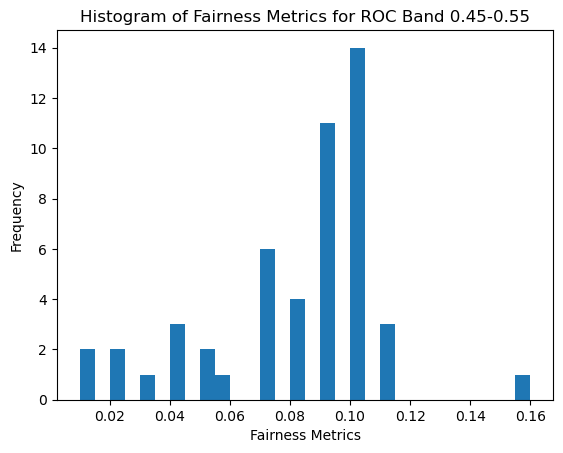

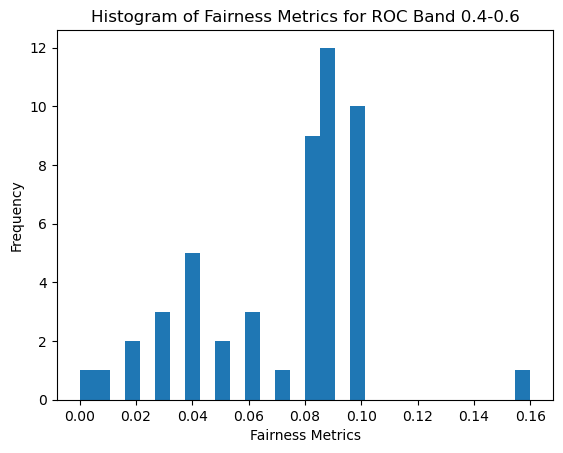

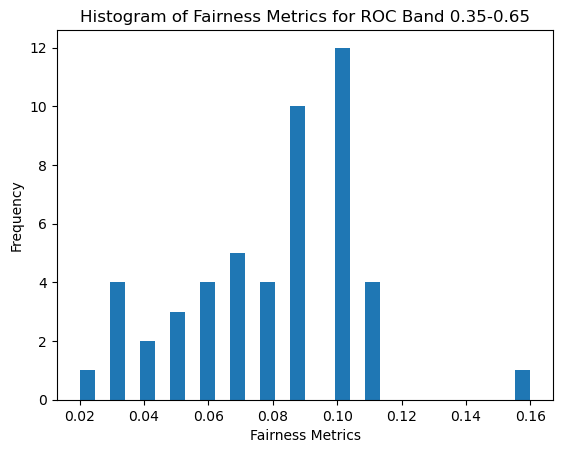

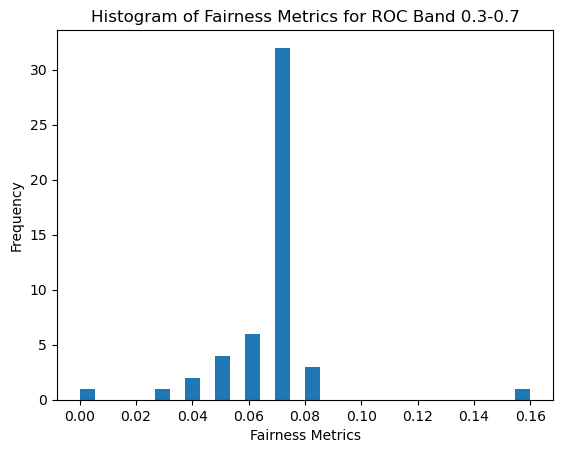

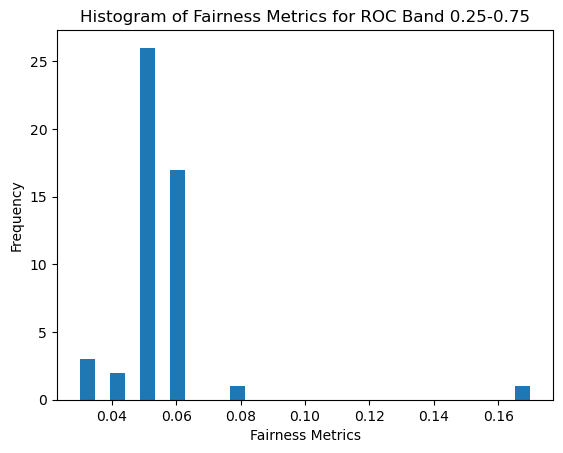

In [12]:
for (low, high), band_df in dfs.items():
    # Plot histogram of fairness metrics for each ROC band
    plt.hist(band_df['fairness_metrics_roc_abs'], bins=30)
    plt.xlabel('Fairness Metrics')
    plt.ylabel('Frequency')
    plt.title('Histogram of Fairness Metrics for ROC Band {}-{}'.format(low, high))
    plt.show()

In [29]:
df_band = dfs[(0.35, 0.65)]

In [30]:
# Select the DataFrame for the ROC band 0.35-0.65 and fairness metric between 0 and 0.06
df_band_fairness = df_band[(df_band['fairness_metrics_roc_abs'] >= 0) & (df_band['fairness_metrics_roc_abs'] <= 0.06)]

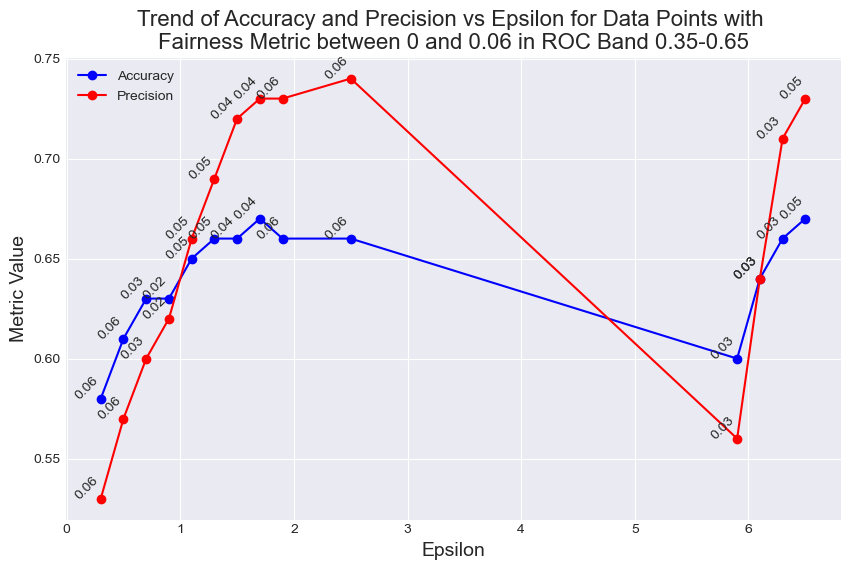

In [31]:
# Set the style of the plot
plt.style.use('seaborn-darkgrid')

# Create a new figure with a specific size
plt.figure(figsize=(10, 6))

# Create a line plot of accuracy vs epsilon
plt.plot(df_band_fairness['epsilon'], df_band_fairness['accuracy'], marker='o', linestyle='-', color='b', label='Accuracy')

# Create a line plot of precision vs epsilon
plt.plot(df_band_fairness['epsilon'], df_band_fairness['precision'], marker='o', linestyle='-', color='r', label='Precision')

# Annotate the data points with their fairness values for accuracy
for i, row in df_band_fairness.iterrows():
    plt.text(row['epsilon'], row['accuracy'], f"{row['fairness_metrics_roc_abs']:.2f}", fontsize=10, ha='right', rotation=45)

# Annotate the data points with their fairness values for precision
for i, row in df_band_fairness.iterrows():
    plt.text(row['epsilon'], row['precision'], f"{row['fairness_metrics_roc_abs']:.2f}", fontsize=10, ha='right', rotation=45)

# Set the labels for the x and y axes
plt.xlabel('Epsilon', fontsize=14)
plt.ylabel('Metric Value', fontsize=14)

# Set the title of the plot
plt.title('Trend of Accuracy and Precision vs Epsilon for Data Points with \nFairness Metric between 0 and 0.06 in ROC Band 0.35-0.65', fontsize=16)

# Add a legend
plt.legend()

# Show the plot
plt.show()

In [59]:
def plot_metrics_vs_epsilon(df, roc_band, fairness_range, metrics):
    # Select the DataFrame for the specified ROC band and fairness metric range
    df_band = df[roc_band]
    df_band_fairness = df_band[(df_band['fairness_metrics_roc_abs'] >= fairness_range[0]) & (df_band['fairness_metrics_roc_abs'] <= fairness_range[1])]

    # Set the style of the plot
    plt.style.use('seaborn-darkgrid')

    # Create a new figure with a specific size
    plt.figure(figsize=(10, 6))

    # Create a line plot for each metric vs epsilon
    for metric in metrics:
        plt.plot(df_band_fairness['epsilon'], df_band_fairness[metric], marker='o', linestyle='-', label=metric.capitalize())

        # Annotate the data points with their fairness values
        for i, row in df_band_fairness.iterrows():
            plt.text(row['epsilon'], row[metric], f"{row['fairness_metrics_roc_abs']:.2f}", fontsize=10, ha='right', rotation=45)

    # Set the labels for the x and y axes
    plt.xlabel('Epsilon', fontsize=14)
    plt.ylabel('Metric Value', fontsize=14)

    # Set the title of the plot
    plt.title(f'Trend of {", ".join([metric.capitalize() for metric in metrics])} vs Epsilon for Data Points with \nFairness Metric between {fairness_range[0]} and {fairness_range[1]} in ROC Band {roc_band[0]}-{roc_band[1]}', fontsize=16)

    # Add a legend
    plt.legend()

    # Show the plot
    plt.show()

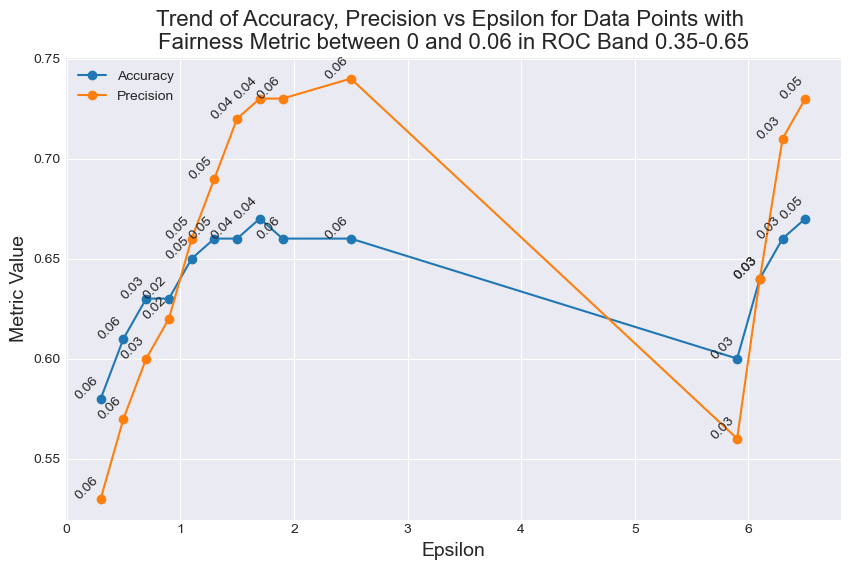

In [60]:
plot_metrics_vs_epsilon(dfs, (0.35, 0.65), (0, 0.06), ['accuracy', 'precision'])

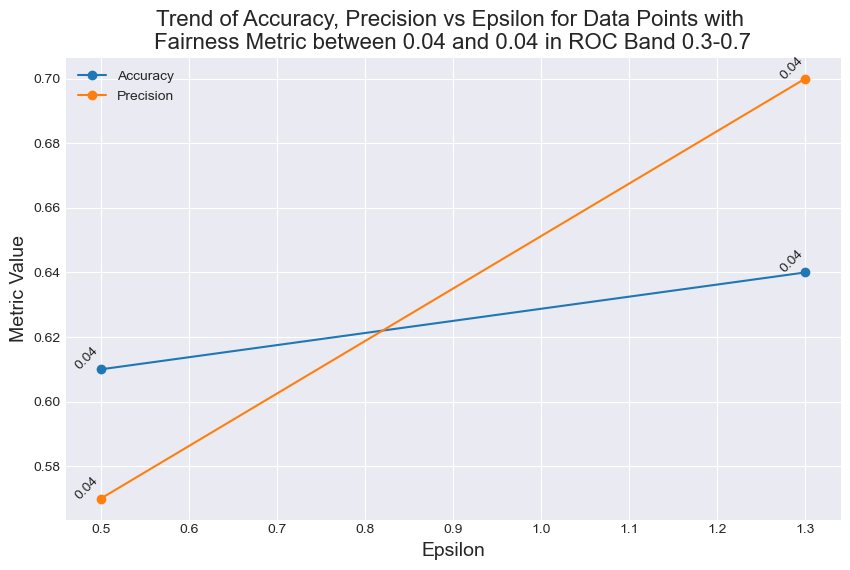

In [56]:
plot_metrics_vs_epsilon(dfs, (0.3, 0.7), (0.04, 0.04), ['accuracy', 'precision'])

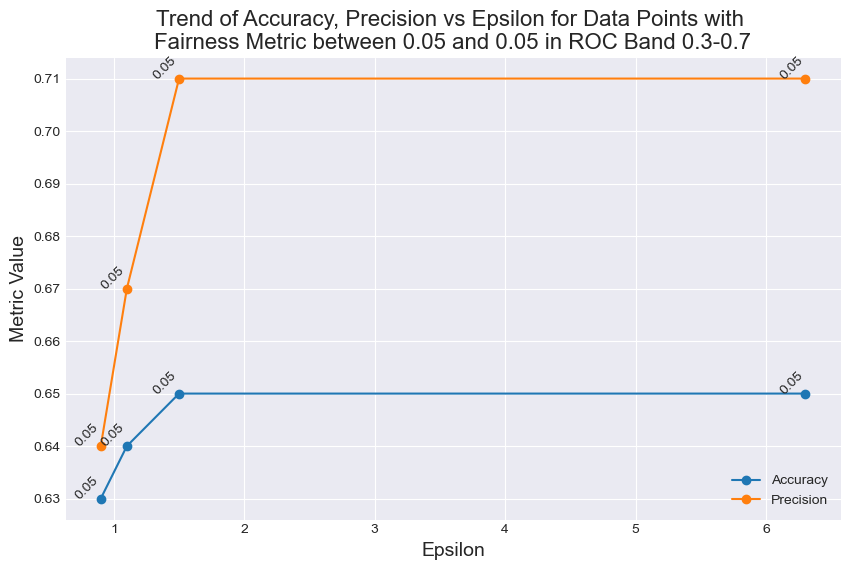

In [61]:
plot_metrics_vs_epsilon(dfs, (0.3, 0.7), (0.05, 0.05), ['accuracy', 'precision'])

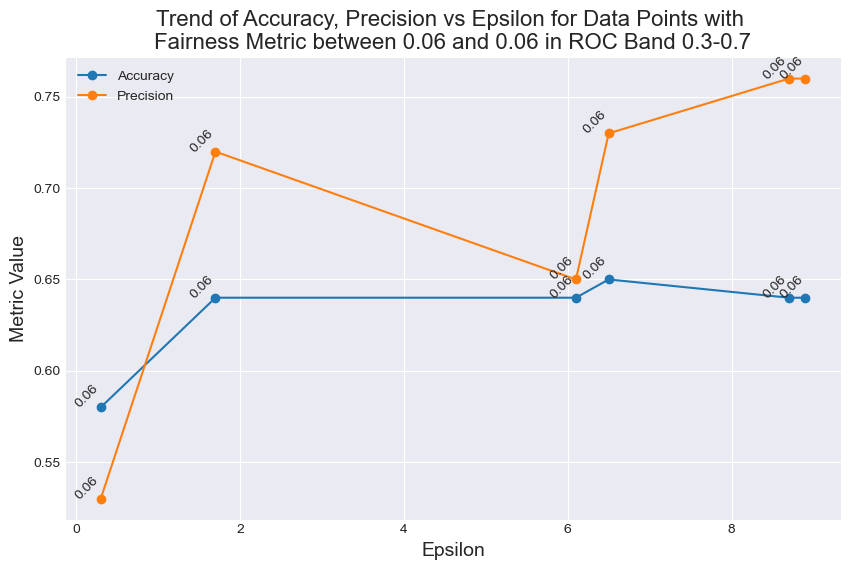

In [62]:
plot_metrics_vs_epsilon(dfs, (0.3, 0.7), (0.06, 0.06), ['accuracy', 'precision'])

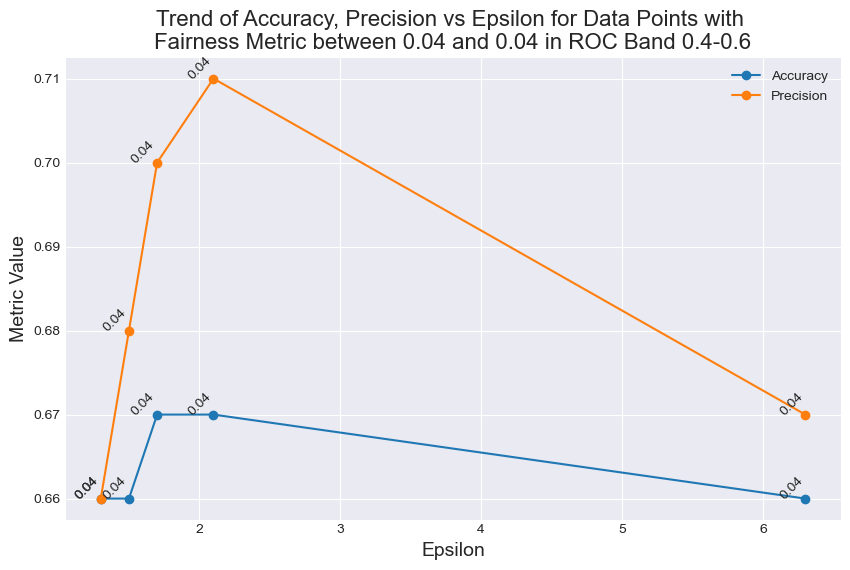

In [64]:
plot_metrics_vs_epsilon(dfs, (0.4, 0.6), (0.04, 0.04), ['accuracy', 'precision'])

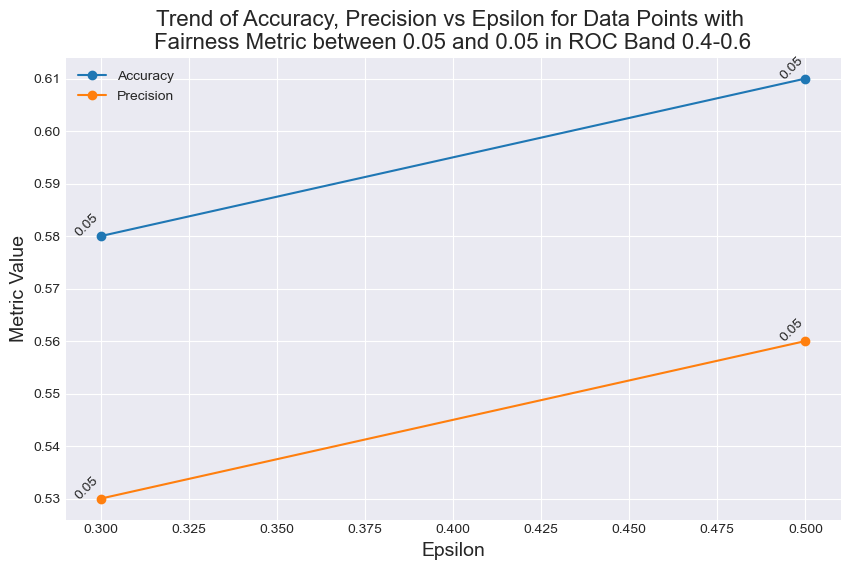

In [65]:
plot_metrics_vs_epsilon(dfs, (0.4, 0.6), (0.05, 0.05), ['accuracy', 'precision'])

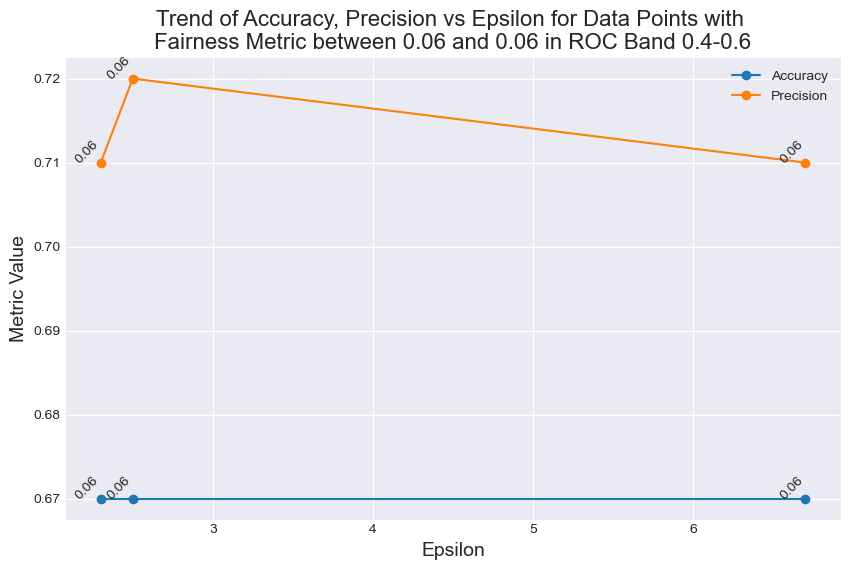

In [66]:
plot_metrics_vs_epsilon(dfs, (0.4, 0.6), (0.06, 0.06), ['accuracy', 'precision'])